Fitche data 

In [2]:
import pandas as pd
path = "/Users/lait-zet/Desktop/Delivery-Time-Prediction/Data/data_livre.csv"

df = pd.read_csv(path)
df.head()


,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,741,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,661,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,412,19.03,Clear,Low,Morning,Bike,16,5.0,68


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Order_ID                1000 non-null   int64  
 1   Distance_km             1000 non-null   float64
 2   Weather                 970 non-null    object 
 3   Traffic_Level           970 non-null    object 
 4   Time_of_Day             970 non-null    object 
 5   Vehicle_Type            1000 non-null   object 
 6   Preparation_Time_min    1000 non-null   int64  
 7   Courier_Experience_yrs  970 non-null    float64
 8   Delivery_Time_min       1000 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 70.4+ KB


In [78]:
df.isnull().sum()
# df.duplicated().sum()

Order_ID                   0
Distance_km                0
Weather                   30
Traffic_Level             30
Time_of_Day               30
Vehicle_Type               0
Preparation_Time_min       0
Courier_Experience_yrs    30
Delivery_Time_min          0
dtype: int64

In [79]:
# df.describe()
df['Weather'].isnull().sum()

np.int64(30)

In [ ]:
import matplotlib.pyplot as plt 
import seaborn as sns

def is_numeric(data):
    i  = 0
    while i < len(data.columns):
        cols  = data.columns[i]
        if data[cols].dtype == 'object':
            data.drop(columns = [cols], inplace = True)
            i -= 1
        i += 1
    return data
Data = is_numeric(df)
corr = Data.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr, vmax=1 , vmin=-1 , annot=True)
plt.title('Heatmap de corrélation des variables numériques')
plt.show()

In [ ]:
categorical_cols = ['Weather', 'Traffic_Level','Time_of_Day', 'Vehicle_Type']
df
for col in categorical_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(x = col , data = df , palette='husl')
    plt.title(f"distribution : {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()



/var/folders/34/r9gx_24s3cn901gzyz1dpgm80000gn/T/ipykernel_3479/1607334120.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = cols ,y = 'Delivery_Time_min' ,data = df ,palette='Set2')


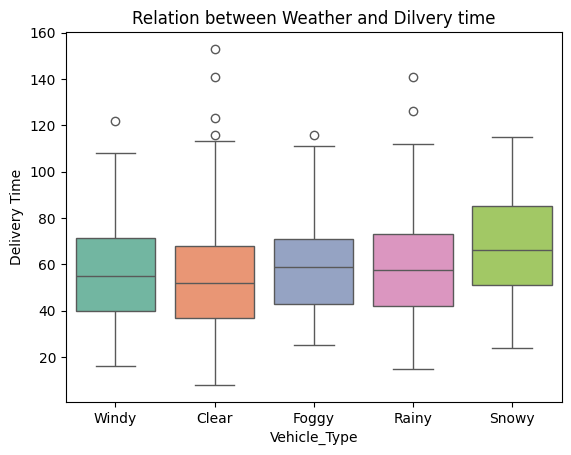

/var/folders/34/r9gx_24s3cn901gzyz1dpgm80000gn/T/ipykernel_3479/1607334120.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = cols ,y = 'Delivery_Time_min' ,data = df ,palette='Set2')


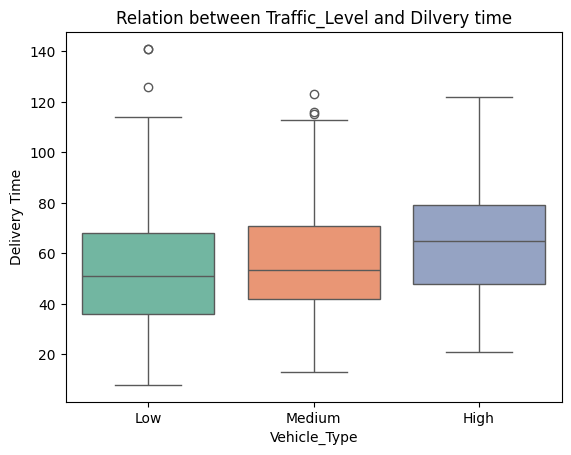

/var/folders/34/r9gx_24s3cn901gzyz1dpgm80000gn/T/ipykernel_3479/1607334120.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = cols ,y = 'Delivery_Time_min' ,data = df ,palette='Set2')


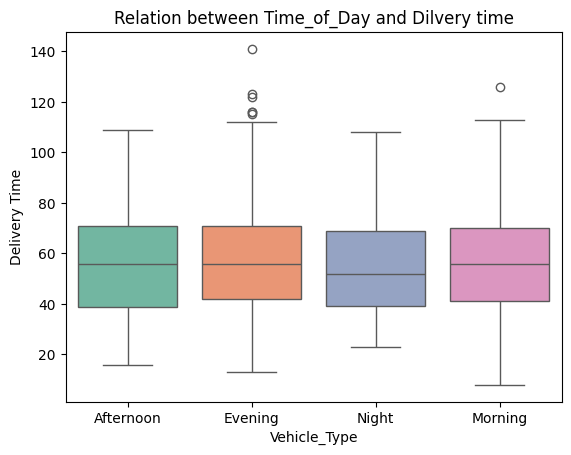

/var/folders/34/r9gx_24s3cn901gzyz1dpgm80000gn/T/ipykernel_3479/1607334120.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = cols ,y = 'Delivery_Time_min' ,data = df ,palette='Set2')


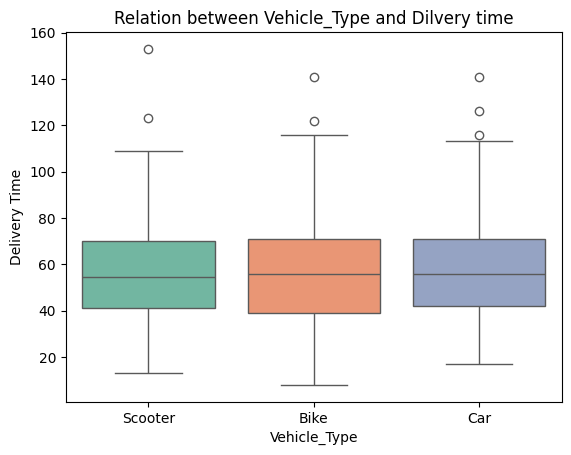

In [40]:
for cols in categorical_cols:
    sns.boxplot(x = cols ,y = 'Delivery_Time_min' ,data = df ,palette='Set2')
    plt.title(f"Relation between {cols} and Dilvery time")
    plt.xlabel(col)
    plt.ylabel("Delivery Time")
    plt.show()

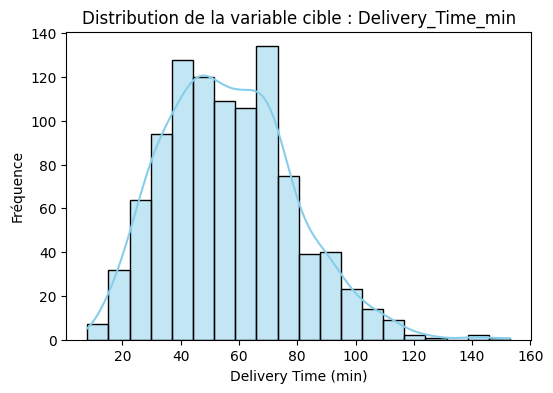

In [41]:
plt.figure(figsize=(6,4))
sns.histplot(df['Delivery_Time_min'], bins=20, kde=True, color='skyblue')
plt.title("Distribution de la variable cible : Delivery_Time_min")
plt.xlabel("Delivery Time (min)")
plt.ylabel("Fréquence")
plt.show()